# Чем мы занимаемся ?

## 1. Данные 

Мы выбрали данные о поездках на такси в Нью Йорке, анализировать мы будем жёлтые такси, которые ездят по Манхеттену. В нашей работе мы будем анализировать чаевые, мы будем смотреть на то были ли они или нет, и попробуем создать модель, которая будет предсказывать их наличие или отсутствие, также планируем сделать модель которая будет предсказывать величину самих чаевых.

In [1]:
import pandas as pd

import numpy as np 

import scipy.stats as sts

import seaborn as sns

import matplotlib.pyplot as plt 

import pyarrow.parquet as pq

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Небольшое введение по поводу предобработки

В данном пункте мы добавляем новые бинарные признаки и не только, которые далее используем в проверке гипотез и ML. Данные фичи:  

- conditions_bin  (1 - если в данный час шёл дождь 0 - нет)
- tips_bin (1 - чаевые были 0 - не было)
- airport_bin (1 - аэропорт был в поездке 0 - не было)
- is_weekend (1 - день является выходнымб 0 - не является) 
- pickup_hour (час когда была начата поездка: от 0 до 23) 
- temp (данные о температуре в данный час) 

Также мы изменили колонку payment_type, мы оставили только два значения в данной колонке 1 - оплата картой 2 - наличные. После мы перекодировали их в 1 (оплата картой) и 0 (оплата наличными). 

Для добавления данных с погодой мы подгрузили два дополнительный дата фрейма за необходимые нам месяца. 

Также мы подгрузили данные которые раскрывают ID мест начала и конца поездки. Данные о местах начала поездки использовались в машинном обучении, однако после было принято решение их не использовать (В самом пункте об этом поподробней). 

In [3]:
df_zones = pd.read_csv('taxi+_zone_lookup.csv')
df_zones.head(70)

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
65,66,Brooklyn,DUMBO/Vinegar Hill,Boro Zone
66,67,Brooklyn,Dyker Heights,Boro Zone
67,68,Manhattan,East Chelsea,Yellow Zone
68,69,Bronx,East Concourse/Concourse Village,Boro Zone


In [4]:
df_weather_june = pd.read_csv('New York City,USA 2022-06-01 to 2022-06-30.csv')
df_weather_june

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"New York City,USA",2022-06-01T00:00:00,19.9,19.9,15.6,75.86,0.0,0,NaN,0,...,1014.2,29.3,16.0,0,NaN,0,10,Partially cloudy,partly-cloudy-night,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301..."
1,"New York City,USA",2022-06-01T01:00:00,19.3,19.3,15.5,78.97,0.0,0,NaN,0,...,1014.0,0.9,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301..."
2,"New York City,USA",2022-06-01T02:00:00,18.3,18.3,14.3,77.59,0.0,0,NaN,0,...,1014.6,29.7,16.0,0,NaN,0,10,Partially cloudy,partly-cloudy-night,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301..."
3,"New York City,USA",2022-06-01T03:00:00,17.2,17.2,13.8,80.53,0.0,0,NaN,0,...,1014.9,89.1,16.0,0,NaN,0,10,Partially cloudy,partly-cloudy-night,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301..."
4,"New York City,USA",2022-06-01T04:00:00,16.7,16.7,13.3,80.48,0.0,0,NaN,0,...,1014.8,99.0,16.0,0,NaN,0,10,Overcast,cloudy,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,"New York City,USA",2022-06-30T19:00:00,27.8,28.0,15.6,47.20,0.0,0,NaN,0,...,1020.3,0.8,16.0,105,0.4,1,10,Clear,clear-day,"72505394728,72055399999,KLGA,KJRB,F1417,KNYC,7..."
716,"New York City,USA",2022-06-30T20:00:00,25.7,25.7,17.0,58.53,0.0,0,NaN,0,...,1020.3,0.4,16.0,18,0.1,0,10,Clear,clear-day,"72505394728,72055399999,KLGA,KJRB,F1417,KNYC,7..."
717,"New York City,USA",2022-06-30T21:00:00,25.0,25.0,18.2,65.88,0.0,0,NaN,0,...,1020.3,0.4,16.0,8,0.0,0,10,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,F1417,KNYC,7..."
718,"New York City,USA",2022-06-30T22:00:00,25.0,25.0,18.3,66.30,0.0,0,NaN,0,...,1020.5,0.4,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,72055399999,KLGA,KJRB,KNYC,7250301..."


In [5]:
df_weather_june['datetime'] = pd.to_datetime(df_weather_june['datetime'])

In [6]:
df_weather_june['conditions'].value_counts()

conditions
Clear                     311
Partially cloudy          204
Overcast                  132
Rain, Overcast             49
Rain, Partially cloudy     14
Rain                       10
Name: count, dtype: int64

In [7]:
df_weather_june['conditions_bin'] = df_weather_june['conditions'].str.contains('Rain').astype(int)

In [8]:
df_weather_june['conditions_bin'].sum()

73

In [9]:
df_weather_december = pd.read_csv('new york 2022-12-01 to 2022-12-31.csv')
df_weather_december

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,new york,2022-12-01T00:00:00,5.2,0.8,-5.6,45.55,0.000,0,NaN,0.0,...,1012.0,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
1,new york,2022-12-01T01:00:00,4.5,-0.2,-5.8,47.16,0.000,0,NaN,0.0,...,1012.9,97.0,16.0,0,NaN,0,10,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
2,new york,2022-12-01T02:00:00,3.6,-0.8,-6.6,47.03,0.000,0,NaN,0.0,...,1013.9,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
3,new york,2022-12-01T03:00:00,3.1,-1.0,-7.3,46.27,0.000,0,NaN,0.0,...,1015.1,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
4,new york,2022-12-01T04:00:00,3.0,-1.3,-8.3,43.33,0.000,0,NaN,0.0,...,1016.1,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,new york,2022-12-31T19:00:00,9.3,9.3,8.1,92.38,0.000,0,NaN,0.0,...,1010.8,100.0,1.5,223,0.8,0,10,Overcast,cloudy,"72505394728,KLGA,D2180,72503014732"
740,new york,2022-12-31T20:00:00,9.4,9.4,8.8,95.77,0.671,100,rain,0.0,...,1009.8,100.0,2.5,225,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
741,new york,2022-12-31T21:00:00,11.6,11.6,10.5,92.71,1.034,100,rain,0.0,...,1008.6,100.0,4.7,225,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
742,new york,2022-12-31T22:00:00,11.2,11.2,10.7,96.73,2.856,100,rain,0.0,...,1008.6,100.0,3.7,227,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"


In [10]:
df_weather_december['datetime'] = pd.to_datetime(df_weather_december['datetime'])

In [11]:
df_weather_december

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,new york,2022-12-01 00:00:00,5.2,0.8,-5.6,45.55,0.000,0,NaN,0.0,...,1012.0,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
1,new york,2022-12-01 01:00:00,4.5,-0.2,-5.8,47.16,0.000,0,NaN,0.0,...,1012.9,97.0,16.0,0,NaN,0,10,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
2,new york,2022-12-01 02:00:00,3.6,-0.8,-6.6,47.03,0.000,0,NaN,0.0,...,1013.9,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
3,new york,2022-12-01 03:00:00,3.1,-1.0,-7.3,46.27,0.000,0,NaN,0.0,...,1015.1,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
4,new york,2022-12-01 04:00:00,3.0,-1.3,-8.3,43.33,0.000,0,NaN,0.0,...,1016.1,7.2,16.0,0,NaN,0,10,Clear,clear-night,"72505394728,KLGA,KNYC,72503014732"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,new york,2022-12-31 19:00:00,9.3,9.3,8.1,92.38,0.000,0,NaN,0.0,...,1010.8,100.0,1.5,223,0.8,0,10,Overcast,cloudy,"72505394728,KLGA,D2180,72503014732"
740,new york,2022-12-31 20:00:00,9.4,9.4,8.8,95.77,0.671,100,rain,0.0,...,1009.8,100.0,2.5,225,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
741,new york,2022-12-31 21:00:00,11.6,11.6,10.5,92.71,1.034,100,rain,0.0,...,1008.6,100.0,4.7,225,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"
742,new york,2022-12-31 22:00:00,11.2,11.2,10.7,96.73,2.856,100,rain,0.0,...,1008.6,100.0,3.7,227,0.8,0,10,"Rain, Overcast",rain,"72505394728,KLGA,D2180,KNYC,72503014732"


In [12]:
df_weather_december['conditions'].value_counts()

conditions
Clear                   317
Partially cloudy        184
Overcast                140
Rain, Overcast           96
Snow, Rain, Overcast      7
Name: count, dtype: int64

In [13]:
df_weather_december['conditions_bin'] = df_weather_december['conditions'].str.contains('Rain').astype(int)

In [14]:
df_weather_december['conditions_bin'].sum()

103

In [15]:
df_december = pq.read_table('yellow_tripdata_2022-12.parquet')
df_december = df_december.to_pandas()

In [16]:
df_december

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-12-01 00:37:35,2022-12-01 00:47:35,1.0,2.00,1.0,N,170,237,1,8.50,3.00,0.5,3.10,0.0,0.3,15.40,2.5,0.00
1,1,2022-12-01 00:34:35,2022-12-01 00:55:21,0.0,8.40,1.0,N,138,141,2,26.00,4.25,0.5,0.00,0.0,0.3,31.05,2.5,1.25
2,1,2022-12-01 00:33:26,2022-12-01 00:37:34,1.0,0.80,1.0,N,140,140,1,5.00,3.00,0.5,1.76,0.0,0.3,10.56,2.5,0.00
3,1,2022-12-01 00:45:51,2022-12-01 00:53:16,1.0,3.00,1.0,N,141,79,3,10.00,3.00,0.5,0.00,0.0,0.3,13.80,2.5,0.00
4,2,2022-12-01 00:49:49,2022-12-01 00:54:13,1.0,0.76,1.0,N,261,231,1,5.00,0.50,0.5,1.76,0.0,0.3,10.56,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399544,2,2022-12-31 23:46:00,2023-01-01 00:11:00,NaN,11.56,NaN,None,16,36,0,39.55,0.00,0.5,8.21,0.0,1.0,49.26,NaN,NaN
3399545,2,2022-12-31 23:13:24,2022-12-31 23:29:08,NaN,5.06,NaN,None,75,50,0,26.23,0.00,0.5,0.00,0.0,1.0,30.23,NaN,NaN
3399546,2,2022-12-31 23:00:49,2022-12-31 23:26:57,NaN,13.35,NaN,None,168,197,0,47.73,0.00,0.5,9.85,0.0,1.0,59.08,NaN,NaN
3399547,1,2022-12-31 23:02:50,2022-12-31 23:16:05,NaN,0.00,NaN,None,238,116,0,12.74,0.00,0.5,0.00,0.0,1.0,16.74,NaN,NaN


In [17]:
df_december['tips_bin'] = np.where(df_december['tip_amount'] > 0, 1, 0)

In [18]:
df_december

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,tips_bin
0,1,2022-12-01 00:37:35,2022-12-01 00:47:35,1.0,2.00,1.0,N,170,237,1,8.50,3.00,0.5,3.10,0.0,0.3,15.40,2.5,0.00,1
1,1,2022-12-01 00:34:35,2022-12-01 00:55:21,0.0,8.40,1.0,N,138,141,2,26.00,4.25,0.5,0.00,0.0,0.3,31.05,2.5,1.25,0
2,1,2022-12-01 00:33:26,2022-12-01 00:37:34,1.0,0.80,1.0,N,140,140,1,5.00,3.00,0.5,1.76,0.0,0.3,10.56,2.5,0.00,1
3,1,2022-12-01 00:45:51,2022-12-01 00:53:16,1.0,3.00,1.0,N,141,79,3,10.00,3.00,0.5,0.00,0.0,0.3,13.80,2.5,0.00,0
4,2,2022-12-01 00:49:49,2022-12-01 00:54:13,1.0,0.76,1.0,N,261,231,1,5.00,0.50,0.5,1.76,0.0,0.3,10.56,2.5,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399544,2,2022-12-31 23:46:00,2023-01-01 00:11:00,NaN,11.56,NaN,None,16,36,0,39.55,0.00,0.5,8.21,0.0,1.0,49.26,NaN,NaN,1
3399545,2,2022-12-31 23:13:24,2022-12-31 23:29:08,NaN,5.06,NaN,None,75,50,0,26.23,0.00,0.5,0.00,0.0,1.0,30.23,NaN,NaN,0
3399546,2,2022-12-31 23:00:49,2022-12-31 23:26:57,NaN,13.35,NaN,None,168,197,0,47.73,0.00,0.5,9.85,0.0,1.0,59.08,NaN,NaN,1
3399547,1,2022-12-31 23:02:50,2022-12-31 23:16:05,NaN,0.00,NaN,None,238,116,0,12.74,0.00,0.5,0.00,0.0,1.0,16.74,NaN,NaN,0


In [19]:
df_december['airport_bin'] = np.where(df_december['airport_fee'] > 0, 1, 0)

In [20]:
df_december

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,tips_bin,airport_bin
0,1,2022-12-01 00:37:35,2022-12-01 00:47:35,1.0,2.00,1.0,N,170,237,1,...,3.00,0.5,3.10,0.0,0.3,15.40,2.5,0.00,1,0
1,1,2022-12-01 00:34:35,2022-12-01 00:55:21,0.0,8.40,1.0,N,138,141,2,...,4.25,0.5,0.00,0.0,0.3,31.05,2.5,1.25,0,1
2,1,2022-12-01 00:33:26,2022-12-01 00:37:34,1.0,0.80,1.0,N,140,140,1,...,3.00,0.5,1.76,0.0,0.3,10.56,2.5,0.00,1,0
3,1,2022-12-01 00:45:51,2022-12-01 00:53:16,1.0,3.00,1.0,N,141,79,3,...,3.00,0.5,0.00,0.0,0.3,13.80,2.5,0.00,0,0
4,2,2022-12-01 00:49:49,2022-12-01 00:54:13,1.0,0.76,1.0,N,261,231,1,...,0.50,0.5,1.76,0.0,0.3,10.56,2.5,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399544,2,2022-12-31 23:46:00,2023-01-01 00:11:00,NaN,11.56,NaN,None,16,36,0,...,0.00,0.5,8.21,0.0,1.0,49.26,NaN,NaN,1,0
3399545,2,2022-12-31 23:13:24,2022-12-31 23:29:08,NaN,5.06,NaN,None,75,50,0,...,0.00,0.5,0.00,0.0,1.0,30.23,NaN,NaN,0,0
3399546,2,2022-12-31 23:00:49,2022-12-31 23:26:57,NaN,13.35,NaN,None,168,197,0,...,0.00,0.5,9.85,0.0,1.0,59.08,NaN,NaN,1,0
3399547,1,2022-12-31 23:02:50,2022-12-31 23:16:05,NaN,0.00,NaN,None,238,116,0,...,0.00,0.5,0.00,0.0,1.0,16.74,NaN,NaN,0,0


In [21]:
df_december[(df_december['payment_type'] == 3) | (df_december['payment_type'] == 4) | (df_december['payment_type'] == 5) | (df_december['payment_type'] == 6)]['tips_bin'].value_counts()

tips_bin
0    57849
1      568
Name: count, dtype: int64

In [22]:
df_december[df_december['payment_type'] == 2]['tips_bin'].value_counts()

tips_bin
0    660712
1       147
Name: count, dtype: int64

In [23]:
med_d = df_december['passenger_count'].median()
med_d

1.0

In [24]:
df_december['passenger_count'].fillna(med_d, inplace=True)

In [25]:
df_december['pickup_hour'] = df_december['tpep_pickup_datetime'].dt.hour

In [26]:
df_december['is_weekend'] = df_december['tpep_pickup_datetime'].dt.dayofweek.isin([5, 6]).astype(int)

In [27]:
start_date = pd.Timestamp('2022-12-01 00:00:00')
end_date = pd.Timestamp('2022-12-31 23:59:59')
df_december = df_december[(start_date <= df_december['tpep_pickup_datetime']) & (df_december['tpep_pickup_datetime'] <= end_date)]

In [28]:
df_december = df_december.sort_values(by='tpep_pickup_datetime', ascending=True)

In [29]:
df_december_mit_weather = pd.merge_asof(df_december, df_weather_december[['datetime', 'temp', 'conditions_bin']], left_on='tpep_pickup_datetime', right_on='datetime')

In [30]:
df_december_mit_weather.drop('datetime', axis=1,  inplace=True)

In [31]:
df_december_mit_weather

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,tips_bin,airport_bin,pickup_hour,is_weekend,temp,conditions_bin
0,2,2022-12-01 00:00:00,2022-12-01 00:09:48,1.0,1.11,1.0,N,230,161,1,...,0.3,13.56,2.5,0.00,1,0,0,0,5.2,0
1,2,2022-12-01 00:00:00,2022-12-01 00:17:00,1.0,6.80,NaN,None,87,262,0,...,0.3,39.62,NaN,NaN,1,0,0,0,5.2,0
2,2,2022-12-01 00:00:01,2022-12-01 00:28:59,2.0,17.46,2.0,N,132,48,2,...,0.3,63.10,2.5,1.25,0,1,0,0,5.2,0
3,2,2022-12-01 00:00:03,2022-12-01 00:14:33,1.0,8.81,1.0,N,138,140,1,...,0.3,36.61,2.5,1.25,1,1,0,0,5.2,0
4,2,2022-12-01 00:00:06,2022-12-01 00:07:35,1.0,1.70,1.0,N,161,239,1,...,0.3,12.80,2.5,0.00,1,0,0,0,5.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399498,2,2022-12-31 23:59:39,2023-01-01 00:04:59,1.0,0.56,1.0,N,164,186,4,...,1.0,11.50,2.5,0.00,0,0,23,1,12.7,1
3399499,2,2022-12-31 23:59:39,2023-01-01 00:04:59,1.0,0.56,1.0,N,164,186,4,...,-1.0,-11.50,-2.5,0.00,0,0,23,1,12.7,1
3399500,2,2022-12-31 23:59:44,2023-01-01 00:07:19,2.0,1.30,1.0,N,79,68,1,...,1.0,14.30,2.5,0.00,0,0,23,1,12.7,1
3399501,2,2022-12-31 23:59:56,2023-01-01 00:13:54,1.0,2.51,1.0,N,237,50,1,...,1.0,26.78,2.5,0.00,1,0,23,1,12.7,1


In [32]:
df_december_mit_weather = df_december_mit_weather[(df_december_mit_weather['payment_type'] == 1) | (df_december_mit_weather['payment_type'] == 2)]

In [33]:
df_december_mit_weather

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,tips_bin,airport_bin,pickup_hour,is_weekend,temp,conditions_bin
0,2,2022-12-01 00:00:00,2022-12-01 00:09:48,1.0,1.11,1.0,N,230,161,1,...,0.3,13.56,2.5,0.00,1,0,0,0,5.2,0
2,2,2022-12-01 00:00:01,2022-12-01 00:28:59,2.0,17.46,2.0,N,132,48,2,...,0.3,63.10,2.5,1.25,0,1,0,0,5.2,0
3,2,2022-12-01 00:00:03,2022-12-01 00:14:33,1.0,8.81,1.0,N,138,140,1,...,0.3,36.61,2.5,1.25,1,1,0,0,5.2,0
4,2,2022-12-01 00:00:06,2022-12-01 00:07:35,1.0,1.70,1.0,N,161,239,1,...,0.3,12.80,2.5,0.00,1,0,0,0,5.2,0
5,2,2022-12-01 00:00:07,2022-12-01 00:11:38,2.0,3.67,1.0,N,48,41,1,...,0.3,19.56,2.5,0.00,1,0,0,0,5.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399496,2,2022-12-31 23:59:34,2023-01-01 00:26:20,1.0,8.47,1.0,N,166,261,2,...,1.0,41.60,2.5,0.00,0,0,23,1,12.7,1
3399497,2,2022-12-31 23:59:36,2023-01-01 00:03:49,1.0,1.20,1.0,N,137,107,1,...,1.0,12.20,2.5,0.00,0,0,23,1,12.7,1
3399500,2,2022-12-31 23:59:44,2023-01-01 00:07:19,2.0,1.30,1.0,N,79,68,1,...,1.0,14.30,2.5,0.00,0,0,23,1,12.7,1
3399501,2,2022-12-31 23:59:56,2023-01-01 00:13:54,1.0,2.51,1.0,N,237,50,1,...,1.0,26.78,2.5,0.00,1,0,23,1,12.7,1


In [34]:
df_december_mit_weather['payment_type'] = np.where(df_december_mit_weather['payment_type'] == 1, 1, 0)

In [35]:
df_december_mit_weather_zone = pd.merge(df_december_mit_weather, df_zones[['LocationID', 'Zone']], how='left', left_on='PULocationID', right_on='LocationID')

In [36]:
df_december_mit_weather_zone.drop('LocationID', axis=1, inplace=True)

In [37]:
df_december_mit_weather_zone

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,airport_fee,tips_bin,airport_bin,pickup_hour,is_weekend,temp,conditions_bin,Zone
0,2,2022-12-01 00:00:00,2022-12-01 00:09:48,1.0,1.11,1.0,N,230,161,1,...,13.56,2.5,0.00,1,0,0,0,5.2,0,Times Sq/Theatre District
1,2,2022-12-01 00:00:01,2022-12-01 00:28:59,2.0,17.46,2.0,N,132,48,0,...,63.10,2.5,1.25,0,1,0,0,5.2,0,JFK Airport
2,2,2022-12-01 00:00:03,2022-12-01 00:14:33,1.0,8.81,1.0,N,138,140,1,...,36.61,2.5,1.25,1,1,0,0,5.2,0,LaGuardia Airport
3,2,2022-12-01 00:00:06,2022-12-01 00:07:35,1.0,1.70,1.0,N,161,239,1,...,12.80,2.5,0.00,1,0,0,0,5.2,0,Midtown Center
4,2,2022-12-01 00:00:07,2022-12-01 00:11:38,2.0,3.67,1.0,N,48,41,1,...,19.56,2.5,0.00,1,0,0,0,5.2,0,Clinton East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214618,2,2022-12-31 23:59:34,2023-01-01 00:26:20,1.0,8.47,1.0,N,166,261,0,...,41.60,2.5,0.00,0,0,23,1,12.7,1,Morningside Heights
3214619,2,2022-12-31 23:59:36,2023-01-01 00:03:49,1.0,1.20,1.0,N,137,107,1,...,12.20,2.5,0.00,0,0,23,1,12.7,1,Kips Bay
3214620,2,2022-12-31 23:59:44,2023-01-01 00:07:19,2.0,1.30,1.0,N,79,68,1,...,14.30,2.5,0.00,0,0,23,1,12.7,1,East Village
3214621,2,2022-12-31 23:59:56,2023-01-01 00:13:54,1.0,2.51,1.0,N,237,50,1,...,26.78,2.5,0.00,1,0,23,1,12.7,1,Upper East Side South


In [38]:
df_june =  pq.read_table('yellow_tripdata_2022-06.parquet')
df_june = df_june.to_pandas()

In [39]:
df_june['tips_bin'] = np.where(df_june['tip_amount'] > 0, 1, 0)

In [40]:
df_june

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,tips_bin
0,1,2022-06-01 00:25:41,2022-06-01 00:48:22,1.0,11.00,1.0,N,70,48,1,32.00,3.00,0.5,2.00,6.55,0.3,44.35,2.5,0.00,1
1,1,2022-06-01 00:44:40,2022-06-01 01:01:48,1.0,4.20,1.0,N,170,226,1,14.00,3.00,0.5,0.00,0.00,0.3,17.80,2.5,0.00,0
2,2,2022-06-01 00:23:07,2022-06-01 00:39:50,1.0,9.49,1.0,N,264,113,1,26.00,0.50,0.5,5.00,6.55,0.3,42.60,2.5,1.25,1
3,1,2022-06-01 00:25:53,2022-06-01 00:57:06,2.0,12.10,1.0,N,132,17,2,37.00,1.75,0.5,0.00,0.00,0.3,39.55,0.0,1.25,0
4,1,2022-06-01 00:23:58,2022-06-01 00:33:43,0.0,1.80,1.0,N,140,163,1,9.00,3.00,0.5,2.55,0.00,0.3,15.35,2.5,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3558119,1,2022-06-30 23:45:51,2022-06-30 23:51:48,NaN,0.00,NaN,None,148,256,0,9.20,0.50,0.5,0.00,0.00,0.3,15.00,NaN,NaN,0
3558120,2,2022-06-30 23:25:00,2022-06-30 23:40:00,NaN,5.01,NaN,None,79,262,0,18.86,0.00,0.5,5.19,0.00,0.3,27.35,NaN,NaN,1
3558121,2,2022-06-30 23:29:00,2022-06-30 23:37:00,NaN,1.55,NaN,None,164,79,0,10.03,0.00,0.5,3.10,0.00,0.3,16.43,NaN,NaN,1
3558122,2,2022-06-30 23:24:15,2022-06-30 23:50:19,NaN,5.30,NaN,None,211,239,0,24.34,0.00,0.5,0.00,0.00,0.3,27.64,NaN,NaN,0


In [41]:
df_june['airport_bin'] = np.where(df_june['airport_fee'] > 0, 1, 0)

In [42]:
df_june

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,tips_bin,airport_bin
0,1,2022-06-01 00:25:41,2022-06-01 00:48:22,1.0,11.00,1.0,N,70,48,1,...,3.00,0.5,2.00,6.55,0.3,44.35,2.5,0.00,1,0
1,1,2022-06-01 00:44:40,2022-06-01 01:01:48,1.0,4.20,1.0,N,170,226,1,...,3.00,0.5,0.00,0.00,0.3,17.80,2.5,0.00,0,0
2,2,2022-06-01 00:23:07,2022-06-01 00:39:50,1.0,9.49,1.0,N,264,113,1,...,0.50,0.5,5.00,6.55,0.3,42.60,2.5,1.25,1,1
3,1,2022-06-01 00:25:53,2022-06-01 00:57:06,2.0,12.10,1.0,N,132,17,2,...,1.75,0.5,0.00,0.00,0.3,39.55,0.0,1.25,0,1
4,1,2022-06-01 00:23:58,2022-06-01 00:33:43,0.0,1.80,1.0,N,140,163,1,...,3.00,0.5,2.55,0.00,0.3,15.35,2.5,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3558119,1,2022-06-30 23:45:51,2022-06-30 23:51:48,NaN,0.00,NaN,None,148,256,0,...,0.50,0.5,0.00,0.00,0.3,15.00,NaN,NaN,0,0
3558120,2,2022-06-30 23:25:00,2022-06-30 23:40:00,NaN,5.01,NaN,None,79,262,0,...,0.00,0.5,5.19,0.00,0.3,27.35,NaN,NaN,1,0
3558121,2,2022-06-30 23:29:00,2022-06-30 23:37:00,NaN,1.55,NaN,None,164,79,0,...,0.00,0.5,3.10,0.00,0.3,16.43,NaN,NaN,1,0
3558122,2,2022-06-30 23:24:15,2022-06-30 23:50:19,NaN,5.30,NaN,None,211,239,0,...,0.00,0.5,0.00,0.00,0.3,27.64,NaN,NaN,0,0


In [43]:
df_june['improvement_surcharge'].value_counts()

improvement_surcharge
 0.3    3534019
-0.3      22671
 0.0       1434
Name: count, dtype: int64

In [44]:
df_june[(df_june['payment_type'] == 3) | (df_june['payment_type'] == 4) | (df_june['payment_type'] == 5) | (df_june['payment_type'] == 6)]['tips_bin'].value_counts()

tips_bin
0    32838
1      271
Name: count, dtype: int64

In [45]:
med_j = df_june['passenger_count'].median()
med_j

1.0

In [46]:
df_june['passenger_count'].fillna(med_j, inplace=True)

In [47]:
df_june['pickup_hour'] = df_june['tpep_pickup_datetime'].dt.hour

In [48]:
df_june['is_weekend'] = df_june['tpep_pickup_datetime'].dt.dayofweek.isin([5, 6]).astype(int)

In [49]:
start_date = pd.Timestamp('2022-06-01 00:00:00')
end_date = pd.Timestamp('2022-06-30 23:59:59')
df_june = df_june[(start_date <= df_june['tpep_pickup_datetime']) & (df_june['tpep_pickup_datetime'] <= end_date)]

In [50]:
df_june = df_june.sort_values(by='tpep_pickup_datetime', ascending=True)

In [51]:
df_june

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,tips_bin,airport_bin,pickup_hour,is_weekend
50914,2,2022-06-01 00:00:00,2022-06-01 14:28:07,1.0,0.38,1.0,N,140,170,2,...,0.00,0.00,0.3,7.80,2.5,0.00,0,0,0,0
3425712,2,2022-06-01 00:00:00,2022-06-01 00:14:00,1.0,3.15,NaN,None,144,256,0,...,1.72,0.00,0.3,17.16,NaN,NaN,1,0,0,0
1747,2,2022-06-01 00:00:01,2022-06-01 00:16:09,3.0,9.53,1.0,N,132,39,1,...,5.66,0.00,0.3,35.21,0.0,1.25,1,1,0,0
234,1,2022-06-01 00:00:01,2022-06-01 00:07:42,1.0,1.40,1.0,N,239,263,1,...,1.13,0.00,0.3,12.43,2.5,0.00,1,0,0,0
410,2,2022-06-01 00:00:07,2022-06-01 00:24:07,1.0,10.55,1.0,N,144,133,1,...,10.46,6.55,0.3,52.31,2.5,0.00,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422070,2,2022-06-30 23:59:55,2022-07-01 00:08:49,1.0,1.80,1.0,N,114,186,1,...,1.00,0.00,0.3,13.30,2.5,0.00,1,0,23,0
3422332,2,2022-06-30 23:59:55,2022-07-01 00:48:44,1.0,13.93,1.0,N,264,219,2,...,0.00,0.00,0.3,50.05,0.0,1.25,0,1,23,0
3422476,1,2022-06-30 23:59:57,2022-07-01 00:19:05,2.0,6.00,1.0,N,234,195,1,...,4.65,0.00,0.3,27.95,2.5,0.00,1,0,23,0
3422325,1,2022-06-30 23:59:58,2022-07-01 00:34:23,2.0,19.30,2.0,N,132,87,2,...,0.00,0.00,0.3,56.55,2.5,1.25,0,1,23,0


In [52]:
df_june_mit_weather = pd.merge_asof(df_june, df_weather_june[['datetime', 'temp', 'conditions_bin']], left_on='tpep_pickup_datetime', right_on='datetime')

In [53]:
df_june_mit_weather.drop('datetime', axis=1, inplace=True)

In [54]:
df_june_mit_weather = df_june_mit_weather[(df_june_mit_weather['payment_type'] == 1) | (df_june_mit_weather['payment_type'] == 2)]

In [55]:
df_june_mit_weather

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,tips_bin,airport_bin,pickup_hour,is_weekend,temp,conditions_bin
0,2,2022-06-01 00:00:00,2022-06-01 14:28:07,1.0,0.38,1.0,N,140,170,2,...,0.3,7.80,2.5,0.00,0,0,0,0,19.9,0
2,2,2022-06-01 00:00:01,2022-06-01 00:16:09,3.0,9.53,1.0,N,132,39,1,...,0.3,35.21,0.0,1.25,1,1,0,0,19.9,0
3,1,2022-06-01 00:00:01,2022-06-01 00:07:42,1.0,1.40,1.0,N,239,263,1,...,0.3,12.43,2.5,0.00,1,0,0,0,19.9,0
4,2,2022-06-01 00:00:07,2022-06-01 00:24:07,1.0,10.55,1.0,N,144,133,1,...,0.3,52.31,2.5,0.00,1,0,0,0,19.9,0
5,1,2022-06-01 00:00:09,2022-06-01 00:21:40,1.0,4.90,1.0,N,148,142,1,...,0.3,21.30,2.5,0.00,0,0,0,0,19.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3557606,2,2022-06-30 23:59:54,2022-07-01 00:06:51,2.0,1.37,1.0,N,164,161,1,...,0.3,10.30,2.5,0.00,0,0,23,0,25.0,0
3557607,2,2022-06-30 23:59:55,2022-07-01 00:08:49,1.0,1.80,1.0,N,114,186,1,...,0.3,13.30,2.5,0.00,1,0,23,0,25.0,0
3557608,2,2022-06-30 23:59:55,2022-07-01 00:48:44,1.0,13.93,1.0,N,264,219,2,...,0.3,50.05,0.0,1.25,0,1,23,0,25.0,0
3557609,1,2022-06-30 23:59:57,2022-07-01 00:19:05,2.0,6.00,1.0,N,234,195,1,...,0.3,27.95,2.5,0.00,1,0,23,0,25.0,0


In [56]:
df_june_mit_weather['payment_type'] = np.where(df_june_mit_weather['payment_type'] == 1, 1, 0)

In [57]:
df_june_mit_weather_zone = pd.merge(df_june_mit_weather, df_zones[['LocationID', 'Zone']], how='left', left_on='PULocationID', right_on='LocationID')

In [58]:
df_june_mit_weather_zone.drop('LocationID', axis=1, inplace=True)

In [64]:
df_june_mit_weather

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,tips_bin,airport_bin,pickup_hour,is_weekend,temp,conditions_bin
0,2,2022-06-01 00:00:00,2022-06-01 14:28:07,1.0,0.38,1.0,N,140,170,0,...,0.3,7.80,2.5,0.00,0,0,0,0,19.9,0
2,2,2022-06-01 00:00:01,2022-06-01 00:16:09,3.0,9.53,1.0,N,132,39,1,...,0.3,35.21,0.0,1.25,1,1,0,0,19.9,0
3,1,2022-06-01 00:00:01,2022-06-01 00:07:42,1.0,1.40,1.0,N,239,263,1,...,0.3,12.43,2.5,0.00,1,0,0,0,19.9,0
4,2,2022-06-01 00:00:07,2022-06-01 00:24:07,1.0,10.55,1.0,N,144,133,1,...,0.3,52.31,2.5,0.00,1,0,0,0,19.9,0
5,1,2022-06-01 00:00:09,2022-06-01 00:21:40,1.0,4.90,1.0,N,148,142,1,...,0.3,21.30,2.5,0.00,0,0,0,0,19.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3557606,2,2022-06-30 23:59:54,2022-07-01 00:06:51,2.0,1.37,1.0,N,164,161,1,...,0.3,10.30,2.5,0.00,0,0,23,0,25.0,0
3557607,2,2022-06-30 23:59:55,2022-07-01 00:08:49,1.0,1.80,1.0,N,114,186,1,...,0.3,13.30,2.5,0.00,1,0,23,0,25.0,0
3557608,2,2022-06-30 23:59:55,2022-07-01 00:48:44,1.0,13.93,1.0,N,264,219,0,...,0.3,50.05,0.0,1.25,0,1,23,0,25.0,0
3557609,1,2022-06-30 23:59:57,2022-07-01 00:19:05,2.0,6.00,1.0,N,234,195,1,...,0.3,27.95,2.5,0.00,1,0,23,0,25.0,0


## 2. Features

Итак говоря о признаках, важно определить какие нам будут нужны в будущем а какие нет, но для начала пройдёмся по всем. 

- VendorID - Указывает провайдера (две компании 1=  Creative Mobile Technologies, LLC 2= VeriFone Inc)

- tpep_pickup_datetime - Дата и время начала поездки 

- tpep_dropoff_datetime - Дата и время окончания поездки 

- Passenger_count - Количество пассажиров указываемое водителем 

- Trip_distance - Дистанция поездки измеренная таксометром

- PULocationID - Место начала поездки 

- DOLocationID -  Пункт назначения 

- RateCodeID - Код ставки применяемой к поездке (1= Standard rate, 2= JFK (аэропорт кеннеди), 3= Newark, 4= Nassau or Westchester, 5= Negotiated fare, 6= Group ride)

- Store_and_fwd_flag - 

- Payment_type - Тип опалаты (1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided Trip)

- Fare_amount - Стоимость поездки рассчитанная по времени и расстоянию

- Extra - Сборы за доп услуги 0.5 долларов В час пик и 1 доллар в ночь 

- MTA_tax - Налог MTA в размере 0,50 доллара США, который автоматически взимается в зависимости от используемой учетной ставки

- Improvement_surcharge - За поездки при сбросе флага взимается дополнительная плата за улучшение в размере 0,30 доллара США. Надбавка за благоустройство начала взиматься в 2015 году.

- Tip_amount - Чаевые 

- Tolls_amount - пошлины 

- Total_amount - сколько всего заплатил пассажир, не включает наличные чаевые 

- Congestion_Surcharge - Общая сумма, взимаемая в поездке за дополнительную плату за пробки в Нью-Йорке.

- Airport_fee - 1,25 доллара за приезд такси только в аэропортах Ла Гуардиа и Джона Ф. Кеннеди

# 3. Гипотезы

- Как правило, в декабре выплачиваются годовые бонусы, поэтому у населения больше денег. Поэтому мы предполагаем что в декабре чаевые таксистам выше, чем в другие месяцы. Для этого мы проверим гипотезу о разности математических ожиданий в декабре и июне. Соответственно H0: мат ожидание в декабре >= мат ожиданию в июне. H1: мат ожидание в декбаре меньше чем в июне. Так как распределения чаевых и истинные параметры нам неизвестны мы будем использовать статистику для случайных величин с неизвестными парамтерами. Проверять гипотезы му будем на уровнях значимости: 0.01, 0.05, 0.1

In [90]:
def tips_diff_one_sided_right(x, y): 
    n = np.size(x)
    m = np.size(y)
    mu0 = 0 
    sigma_x = np.var(x, ddof=1)
    sigma_y = np.var(y, ddof=1)
    z_stat = (np.mean(x) - np.mean(y) - mu0) / np.sqrt((sigma_x / n) + (sigma_y / m))
    alphas = [0.01, 0.05, 0.1]
    for alpha in alphas:
        z_left_crit = -1 * sts.norm.ppf(1-alpha)
        if  (z_stat > z_left_crit):
            print(f'Нулевая гипотеза не отвергается на уровне значимости {alpha}')
        else:
            print(f'Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости {alpha}')

In [91]:
tips_diff_one_sided_right(df_december['tip_amount'].values, df_june['tip_amount'].values)

Нулевая гипотеза не отвергается на уровне значимости 0.01
Нулевая гипотеза не отвергается на уровне значимости 0.05
Нулевая гипотеза не отвергается на уровне значимости 0.1


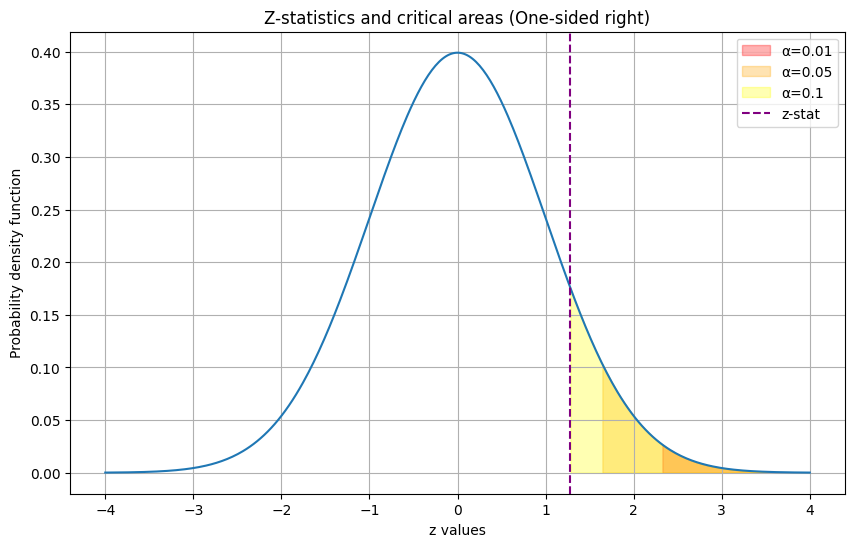

In [92]:
def tips_diff_one_sided_right(x, y):
    n = np.size(x)
    m = np.size(y)
    mu0 = 0 
    sigma_x = np.var(x, ddof=1)
    sigma_y = np.var(y, ddof=1)
    z_stat = (np.mean(x) - np.mean(y) - mu0) / np.sqrt((sigma_x / n) + (sigma_y / m))
    return z_stat

def plot_z_stat_one_sided_right(z_stat):
    z_values = np.linspace(-4, 4, 400)
    normal_dist = sts.norm.pdf(z_values, 0, 1)

    plt.figure(figsize=(10, 6))
    plt.plot(z_values, normal_dist)

    alphas = [0.01, 0.05, 0.1]
    colors = ['red', 'orange', 'yellow']
    for alpha, color in zip(alphas, colors):
        z_right_crit = sts.norm.ppf(1-alpha)
        critical_area = np.linspace(z_right_crit, 4, 400)
        plt.fill_between(critical_area, sts.norm.pdf(critical_area, 0, 1), color=color, alpha=0.3, label=f'α={alpha}')

    plt.axvline(z_stat, color='purple', linestyle='dashed', linewidth=1.5, label='z-stat')

    plt.legend()
    plt.title('Z-statistics and critical areas (One-sided right)')
    plt.xlabel('z values')
    plt.ylabel('Probability density function')
    plt.grid(True)
    plt.show()

z_stat = tips_diff_one_sided_right(df_december['tip_amount'].values, df_june['tip_amount'].values)
plot_z_stat_one_sided_right(z_stat)


**Вывод:** Из данной гипотезы мы понимаем, что наше предположение о том что в декабре платят чаевых больше, что важно наша гипотеза не отвергается на всех заданных уровнях значимости. Таким образом, можно утверждать, что в декабре платят больше чаевых. Естественно причины могут быть разными, однако наше предположение о выплатах годовых бонусов не лишены смысла в таком контексте. 

Гипотеза о доле, для проверки данной гипотезы мы ввели в дата фреймы бинарные столбцы, где у нас есть 1 если чаевые больше 0 и 0, если чаевые равны нулю. И теперь мы хотим проверить гипотезу что в каждом из месяцев доля чаевых равна 0.5. Для этого будем использовать критические области. Смысл данной гипотезы заключается в том, что мы хотим понять природу того как вообще выдают чаевые, для начала предположим что вероятность, что пассажир заплатит чаевые равна 0.5, это наша H0, соответственно наша H1 это то что вероятность получить чаевые больше или меньше 0.5.

In [96]:
def prop_hyp(x):
    p0 = 0.5
    p_hat = np.mean(x)
    n = np.size(x)
    z_stat = ((p_hat - p0) / np.sqrt(p_hat * (1 - p_hat))) * np.sqrt(n)
    alphas = [0.01, 0.05, 0.1]
    for alpha in alphas:
        z_crit_left = -1 * sts.norm.ppf(1-alpha/2)
        z_crit_right = sts.norm.ppf(1-alpha/2)
        if (z_stat > z_crit_left) & (z_stat < z_crit_right):
            print(f'Нулевая гипотеза не отвергается на уровне значимости {alpha}')
        else: 
            print(f'Нулевая гипиотеза отвергается в пользу альтернативной на уровне значимости {alpha}')
    return z_stat

In [97]:
prop_hyp(df_december['tips_bin'].values)

Нулевая гипиотеза отвергается в пользу альтернативной на уровне значимости 0.01
Нулевая гипиотеза отвергается в пользу альтернативной на уровне значимости 0.05
Нулевая гипиотеза отвергается в пользу альтернативной на уровне значимости 0.1


1076.855030874104

In [98]:
prop_hyp(df_june['tips_bin'].values)

Нулевая гипиотеза отвергается в пользу альтернативной на уровне значимости 0.01
Нулевая гипиотеза отвергается в пользу альтернативной на уровне значимости 0.05
Нулевая гипиотеза отвергается в пользу альтернативной на уровне значимости 0.1


1151.6275613412831

**Вывод:** В данной гипотезе мы ставили себе цель проверить являются ли чаевыми случайными. И мы получили занимательные выводы. Получается чаевые оставляют не случайно. Далее мы решили проверить односторонюю гипотезу о том что вероятность чаевых больше чем 0.5 или равна. Пусть кажется что мы проверяем ту же гипотезу, но в действительности мы изначально не предполагали что чаевые не случайны, соответственно теперь мы попытаемся узнать какова вероятность получения чаевых.

А теперь проверим односторонюю гипотезы для доли. Проверяем гипотезу что наша доля чаевых больше или равна 0.5

In [101]:
def prop_hyp_one_sided(x): 
    p0 = 0.5
    p_hat = np.mean(x)
    n = np.size(x)
    z_stat = ((p_hat - p0) / np.sqrt(p_hat * (1 - p_hat))) * np.sqrt(n)
    alphas = [0.01, 0.05, 0.1]
    for alpha in alphas:
        z_crit_left = -1 * sts.norm.ppf(1-alpha)
        if (z_stat > z_crit_left):
            print(f'Нулевая гипотеза не отвергается на уровне значимости {alpha}')
        else: 
            print(f'Нулевая гипиотеза отвергается в пользу альтернативной на уровне значимости {alpha}')
    return z_stat

In [102]:
prop_hyp_one_sided(df_december['tips_bin'].values)

Нулевая гипотеза не отвергается на уровне значимости 0.01
Нулевая гипотеза не отвергается на уровне значимости 0.05
Нулевая гипотеза не отвергается на уровне значимости 0.1


1076.855030874104

In [103]:
prop_hyp_one_sided(df_june['tips_bin'].values)

Нулевая гипотеза не отвергается на уровне значимости 0.01
Нулевая гипотеза не отвергается на уровне значимости 0.05
Нулевая гипотеза не отвергается на уровне значимости 0.1


1151.6275613412831

**Вывод:** Теперь можно сделать вывод что чаевые оставляют чаще чем не оставляют. Таким образом становится понятно, что это не случайное событие и что в Нью-Йорке в целом принято оставлять чаевые таксистам. 

Теперь интерессно проверить когда таксист вероятнее получит чаевые. Для этого мы будем проверять гипотезу о разности долей. Нулевая гипотеза у нас будет такая что разность долей будет либо равна нулю либо больше нуля (будем вычитать из доли декабря долю июня) альтернатвиная гипотеза будет такая, что в июне доля чаевых больше. 

In [93]:
def prop_diff(x, y):
    px_hat = np.mean(x)
    py_hat = np.mean(y)
    p0 = 0 
    n = np.size(x)
    m = np.size(y)
    z_stat = (px_hat - py_hat - p0) / np.sqrt(((px_hat * (1 - px_hat)) / n) + ((py_hat * (1 - py_hat)) / m))
    alphas = [0.01, 0.05, 0.1]
    for alpha in alphas:
        z_crit = -1 * sts.norm.ppf(1-alpha)
        if z_stat > z_crit:
            print(f'Нулевая гипотеза не отвергается на уровне значимости {alpha}')
        else:
            print(f'Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости {alpha}')
    return z_stat

In [94]:
prop_diff(df_december['tips_bin'].values, df_june['tips_bin'].values)

Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.01
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.05
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.1


-25.765360762669264

**Вывод:** В данной гипотезе мы проверям, в каком месяце чаще дают чаевые, как мы ранее предположили, что в декабре чаевые в среднем выше, чем в июне. Соответственно мы подумали что в декабре пассажиры их также будут чаще оставлять, чем в июне. Однако  после проверки гипотезы, получилось всё совершенно наоборот, в июне чаевые оставляют чаще чем в декабре. В то же время средняя величина выше в декабре. Отсюда можно сделать вывод, что в июне чаевые оставляют чаще, однако в меньшем объёме. 

Теперь перейдём к следующей части проверки гипотез. В данном разделе мы будем проверять гипотезы на независимость событий и естественно в каждой из них фигурируют чаевые. 

Проверим гипотезу о независимости событий: пассажир заплатил чаевые и пассажир ехал или уезжал из аэропорта. Почему мне кажетсся что это имеет смысл, потому что пассажир может дать чаевые водителю за то что тот ему поможет выгрузить из машины чемоданы и соответственно может помочь загрузить их в авто. Проверять гипотезу мы будем с помощью chi2_contingency. 

In [159]:
def airoport_and_tips(x, y):
    contigency_table = pd.crosstab(x, y)
    p_value= sts.chi2_contingency(contigency_table)[1]
    alphas = [0.01, 0.05, 0.1]
    print(f'p_value: {p_value}')
    for alpha in alphas:
        if p_value > alpha: 
            print(f'Нулевая гипотеза не отвергается на уровне значимости {alpha}')
        else:
            print(f'Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости {alpha}')

In [160]:
airoport_and_tips(df_december['tips_bin'], df_december['airport_bin'])

p_value: 0.0
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.01
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.05
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.1


In [120]:
contigency_table_dec = pd.crosstab(df_december['tips_bin'], df_december['airport_bin'])
contigency_table_dec

airport_bin,0,1
tips_bin,,
0,759684,82828
1,2359861,197130


In [123]:
p_tips_airport_yes = contigency_table_dec[1][1] / contigency_table_dec[1].sum()
p_tips_airport_no = contigency_table_dec[0][1] / contigency_table_dec[0].sum()
print(f'Доля чаевых когда в поездке фигурировал аэропорт: {p_tips_airport_yes}')
print(f'Доля чаевых когда в поездке не фигурировал аэропорт: {p_tips_airport_no}')

Доля чаевых когда в поездке фигурировал аэропорт: 0.7041413354860372
Доля чаевых когда в поездке не фигурировал аэропорт: 0.7564760245484518


In [124]:
airoport_und_tips(df_june['tips_bin'], df_june['airport_bin'])

p_value: 0.0
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.01
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.05
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.1


In [125]:
contigency_table_jun = pd.crosstab(df_june['tips_bin'], df_june['airport_bin'])
contigency_table_jun

airport_bin,0,1
tips_bin,,
0,776099,75751
1,2516798,188964


In [126]:
p_tips_airport_yes = contigency_table_jun[1][1] / contigency_table_jun[1].sum()
p_tips_airport_no = contigency_table_jun[0][1] / contigency_table_jun[0].sum()
print(f'Доля чаевых когда в поездке фигурировал аэропорт: {p_tips_airport_yes}')
print(f'Доля чаевых когда в поездке не фигурировал аэропорт: {p_tips_airport_no}')

Доля чаевых когда в поездке фигурировал аэропорт: 0.7138394121980243
Доля чаевых когда в поездке не фигурировал аэропорт: 0.7643111825240814


**Вывод:** Данную гипотезу мы решили проверить предполагая то, что есть некоторые события который могут влиять на чаевые. Например был ли в поездке аэропорт. Мы предположили что между ними есть какая то зависимость. Далее проверили гипотезу на независимость и она отверглась. Далее мы решили понять, каким образом влияет аэропорт на чаевые и в каждом из двух месяцев мы получили одинаковые результаты. В каждом из двух месяцев доля чаевых выше когда аэропорт не фигурировал в поездке. Таким образом мы можем предполагать что аэропорт негативно влияет на вероятность того что пассажир оставит чаевые. 

Гипотеза о независимости чаевых от того идёт ли дождь или нет. Мы проверим данную гипотезу через функцию chi2_contigency

In [127]:
def rain_und_tips(x, y):
    contigency_table = pd.crosstab(x, y)
    p_value = sts.chi2_contingency(contigency_table)[1]
    alphas = [0.01, 0.05, 0.1]
    print(f'p_value: {p_value}')
    for alpha in alphas:
        if p_value > alpha: 
            print(f'Нулевая гипотеза не отвергается на уровне значимости {alpha}')
        else:
            print(f'Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости {alpha}')

In [128]:
rain_und_tips(df_december_mit_weather_zone['tips_bin'], df_december_mit_weather_zone['conditions_bin'])

p_value: 2.6835420859681984e-121
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.01
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.05
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.1


In [129]:
rain_und_tips(df_june_mit_weather_zone['tips_bin'], df_june_mit_weather_zone['conditions_bin'])

p_value: 5.626355234987128e-18
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.01
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.05
Нулевая гипотеза отвергается в пользу альтернативной на уровне значимости 0.1


**Вывод:** Гипотеза о независимости отверглась, поэтому теперь мы проверим, какое влияние оказывает дождь на вероятность получить чаевые.

In [130]:
contigency_table_dec_2 = pd.crosstab(df_december_mit_weather_zone['tips_bin'], df_december_mit_weather_zone['conditions_bin'])
p_tips_rain_yes = contigency_table_dec_2[1][1] / contigency_table_dec_2[1].sum()
p_tips_rain_no = contigency_table_dec_2[0][1] / contigency_table_dec_2[0].sum()
print(f'Доля чаевых когда был дождь: {p_tips_rain_yes}')
print(f'Доля чаевых когда не было дождя: {p_tips_rain_no}')

Доля чаевых когда был дождь: 0.7743165860666519
Доля чаевых когда не было дождя: 0.7588766852680089


In [131]:
contigency_table_dec_2

conditions_bin,0,1
tips_bin,,
0,655955,111535
1,2064458,382675


In [132]:
contigency_table_jun_2 = pd.crosstab(df_june_mit_weather_zone['tips_bin'], df_june_mit_weather_zone['conditions_bin'])
p_tips_rain_yes = contigency_table_jun_2[1][1] / contigency_table_jun_2[1].sum()
p_tips_rain_no = contigency_table_jun_2[0][1] / contigency_table_jun_2[0].sum()
print(f'Доля чаевых когда был дождь: {p_tips_rain_yes}')
print(f'Доля чаевых когда не было дождя: {p_tips_rain_no}')

Доля чаевых когда был дождь: 0.768637347983491
Доля чаевых когда не было дождя: 0.7621811276704196


In [133]:
contigency_table_jun_2

conditions_bin,0,1
tips_bin,,
0,720380,83974
1,2308732,278980


**Вывод:** После отвержения гипотезы о независимости, мы решили проверить доли когда дают чаевые в зависимости от другого события в данном случае это дождь. Как и в прошлый раз событие оказывает влияние на оба месяца, в каждом из месяцев дождь позитивно влияет на чаевые, конечно на довольно малые величины, но всё же влияние есть. 